In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from itertools import product

sys.path.append('./OptimizersArticle')

from data_generator.data_generator import (
    generate_data,
    construct_bounds,
    construct_lp_grid
)

from optimizers.optimizers import (
    ScipyNlpOptimizationModel,
    PyomoNlpOptimizationModel,
    PyomoLpOptimizationModel,
    CvxpyLpOptimizationModel
)
from optimizers.optimization import pricing_optimization


In [4]:
bounds_params = {
    'main_bounds': {
        'lower': 0.9, 'upper': 1.1
    },
    'market_bounds': {
        'lower': 0.85, 'upper': 1.15
    }
}


In [100]:
seed_grid = list(range(25))
N_grid = [10, 20, 50, 100, 200, 500, 1000]

stats_df_list = []

for N, seed in product(N_grid, seed_grid):
    print('--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--')
    print(N, seed)
    # генерация данных для непрерывной NLP оптимизации
    data_c = generate_data(N, seed)
    data_c = construct_bounds(data_c, bounds_params)
    # генерация данных для MILP оптимизации
    data_d = construct_lp_grid(data_c, bounds_params, 21)
    
    M_cur = sum(data_c['Q'] * (data_c['P'] - data_c['C']))
    P_cur = sum(data_c['Q'] * data_c['P'])

    opt_params = {
        'alpha': 0.0,
        'con_mrg': M_cur,
        'con_equal': True
    }
    
    statuses = []
    times = []
    solvers = []

    if N < 1000:    
        res, t = pricing_optimization(data_c, ScipyNlpOptimizationModel, opt_params, 'slsqp')
        statuses.append('ok' if res['status'] == '0' else res['status'])
        times.append(t)
        solvers.append('slsqp')
        print(f'slsqp finish \t{t}')
    
    if N < 500:
        res, t = pricing_optimization(data_c, ScipyNlpOptimizationModel, opt_params, 'trust-constr')
        statuses.append('ok' if res['status'] == '1' else res['status'])
        times.append(t)
        solvers.append('trust-constr')
        print(f'trust finish \t{t}')

    res, t = pricing_optimization(data_c, PyomoNlpOptimizationModel, opt_params, 'ipopt')
    statuses.append('ok' if res['status'] == 'ok' else res['status'])
    times.append(t)
    solvers.append('ipopt')
    print(f'ipopt finish \t{t}')

    res, t = pricing_optimization(data_d, PyomoLpOptimizationModel, opt_params, 'cbc')
    statuses.append('ok' if res['status'] == 'ok' else res['status'])
    times.append(t)
    solvers.append('pyomo_cbc')
    print(f'pyomo cbc finish \t{t}')

    res, t = pricing_optimization(data_d, PyomoLpOptimizationModel, opt_params, 'glpk')
    statuses.append('ok' if res['status'] == 'ok' else res['status'])
    times.append(t)
    solvers.append('pyomo_glpk')
    print(f'pyomo glpk finish \t{t}')
    
    res, t = pricing_optimization(data_d, CvxpyLpOptimizationModel, opt_params, 'CBC')
    statuses.append('ok' if res['status'] == 'optimal' else res['status'])
    times.append(t)
    solvers.append('cvxpy_cbc')
    print(f'cvxpy cbc finish \t{t}')
    
    res, t = pricing_optimization(data_d, CvxpyLpOptimizationModel, opt_params, 'GLPK_MI')
    statuses.append('ok' if res['status'] == 'optimal' else res['status'])
    times.append(t)
    solvers.append('cvxpy_glpk')
    print(f'cvxpy glpk finish \t{t}')    
    
    if N < 2000:
        res, t = pricing_optimization(data_d, CvxpyLpOptimizationModel, opt_params, 'ECOS_BB')
        statuses.append('ok' if res['status'] == 'optimal' else res['status'])
        times.append(t)
        solvers.append('ecos')
        print(f'ecos finish \t{t}')

    stats_df_list.append(pd.DataFrame({
        'N': N,
        'seed': seed,
        'solver': solvers,
        't': times,
        'status': statuses
    }))
    
stats_df = pd.concat(stats_df_list)
stats_df.to_csv('./data/optimizers_stats.csv', index=None)


--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
10 0
slsqp finish 	0.016166210174560547
trust finish 	0.269956111907959
ipopt finish 	0.08144092559814453
pyomo cbc finish 	0.113739013671875
pyomo glpk finish 	0.052060842514038086
cvxpy cbc finish 	0.026734113693237305
cvxpy glpk finish 	0.012995004653930664
ecos finish 	0.015892982482910156
--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
10 1
slsqp finish 	0.02078104019165039
trust finish 	0.18880414962768555
ipopt finish 	0.043869972229003906
pyomo cbc finish 	0.13658499717712402
pyomo glpk finish 	0.040058135986328125
cvxpy cbc finish 	0.08659625053405762
cvxpy glpk finish 	0.015506267547607422
ecos finish 	2.2466938495635986
--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
10 2
slsqp finish 	0.01044607162475586
trust finish 	0.6845710277557373
ipopt finish 	0.05547165870666504
pyomo cbc finish 	0.07586002349853516
pyomo glpk finish 	0.04190802574157715
cvxpy cbc finish 	0.02273607254028320

/Users/budylin/Documents/work/optimizer_read/optimizer_code_env/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:186: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


pyomo glpk finish 	0.04526805877685547
cvxpy cbc finish 	0.02219080924987793
cvxpy glpk finish 	0.01305079460144043
ecos finish 	0.015416145324707031
--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
10 6
slsqp finish 	0.016937971115112305
trust finish 	0.3301851749420166
ipopt finish 	0.05299186706542969
pyomo cbc finish 	0.07666301727294922
pyomo glpk finish 	0.0424199104309082
cvxpy cbc finish 	0.023807048797607422
cvxpy glpk finish 	0.013296127319335938
ecos finish 	0.013796091079711914
--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
10 7
slsqp finish 	0.01854395866394043
trust finish 	0.3676748275756836
ipopt finish 	0.04849505424499512
pyomo cbc finish 	0.0897979736328125
pyomo glpk finish 	0.0391697883605957
cvxpy cbc finish 	0.06684017181396484
cvxpy glpk finish 	0.017611026763916016
ecos finish 	1.4890468120574951
--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
10 8
slsqp finish 	0.010776042938232422
trust finish 	0.44840192794799805


pyomo cbc finish 	0.12126898765563965
pyomo glpk finish 	0.05257701873779297
cvxpy cbc finish 	0.12597227096557617
cvxpy glpk finish 	0.015259981155395508
ecos finish 	4.906873941421509
--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
20 4
slsqp finish 	0.012463092803955078
trust finish 	0.5929229259490967
ipopt finish 	0.051167964935302734
pyomo cbc finish 	0.07571792602539062
pyomo glpk finish 	0.045278310775756836
cvxpy cbc finish 	0.023247718811035156
cvxpy glpk finish 	0.012463092803955078
ecos finish 	0.016315937042236328
--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
20 5
slsqp finish 	0.01459193229675293
trust finish 	0.7924787998199463
ipopt finish 	0.05362081527709961
pyomo cbc finish 	0.08711886405944824
pyomo glpk finish 	0.05294680595397949
cvxpy cbc finish 	0.07070708274841309
cvxpy glpk finish 	0.013939142227172852
ecos finish 	4.773638963699341
--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
20 6
slsqp finish 	0.0139830112457

ipopt finish 	0.059977054595947266
pyomo cbc finish 	0.16316699981689453
pyomo glpk finish 	0.08741402626037598
cvxpy cbc finish 	0.04111504554748535
cvxpy glpk finish 	0.01855778694152832
ecos finish 	11.109797239303589
--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
50 2
slsqp finish 	0.06397676467895508
trust finish 	2.7316882610321045
ipopt finish 	0.06025981903076172
pyomo cbc finish 	0.46730804443359375
pyomo glpk finish 	0.11692380905151367
cvxpy cbc finish 	0.2906970977783203
cvxpy glpk finish 	0.06893205642700195
ecos finish 	0.032225847244262695
--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
50 3
slsqp finish 	0.04134416580200195
trust finish 	2.5245141983032227
ipopt finish 	0.07296609878540039
pyomo cbc finish 	0.4908168315887451
pyomo glpk finish 	0.10895705223083496
cvxpy cbc finish 	0.2785630226135254
cvxpy glpk finish 	0.07944178581237793
ecos finish 	11.268552780151367
--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
50 4
sl

ipopt finish 	0.0692129135131836
pyomo cbc finish 	0.11351203918457031
pyomo glpk finish 	0.08396482467651367
cvxpy cbc finish 	0.030743837356567383
cvxpy glpk finish 	0.014974832534790039
ecos finish 	0.028153181076049805
--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
100 0
slsqp finish 	0.1658797264099121
trust finish 	8.95519208908081
ipopt finish 	0.09572696685791016
pyomo cbc finish 	0.21251606941223145
pyomo glpk finish 	0.3130228519439697
cvxpy cbc finish 	0.04370474815368652
cvxpy glpk finish 	0.021932125091552734
ecos finish 	0.051985979080200195
--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
100 1
slsqp finish 	0.162337064743042
trust finish 	11.433897018432617
ipopt finish 	0.08539295196533203
pyomo cbc finish 	0.1850118637084961
pyomo glpk finish 	0.1394808292388916
cvxpy cbc finish 	0.040049076080322266
cvxpy glpk finish 	0.020526885986328125
ecos finish 	0.056416988372802734
--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
100

pyomo cbc finish 	0.3443326950073242
pyomo glpk finish 	0.19896292686462402
cvxpy cbc finish 	0.27440929412841797
cvxpy glpk finish 	0.11857891082763672
ecos finish 	0.0680539608001709
--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
100 23
slsqp finish 	0.2626228332519531
trust finish 	5.782936096191406
ipopt finish 	0.09249591827392578
pyomo cbc finish 	0.37372684478759766
pyomo glpk finish 	0.3576931953430176
cvxpy cbc finish 	0.14442181587219238
cvxpy glpk finish 	0.1504361629486084
ecos finish 	0.06769585609436035
--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
100 24
slsqp finish 	0.23473310470581055
trust finish 	8.232928037643433
ipopt finish 	0.0956871509552002
pyomo cbc finish 	0.27512288093566895
pyomo glpk finish 	0.1498732566833496
cvxpy cbc finish 	0.06638503074645996
cvxpy glpk finish 	0.029612064361572266
ecos finish 	31.84996199607849
--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
200 0
slsqp finish 	2.1829590797424316
trust

ecos finish 	0.17114996910095215
--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
200 21
slsqp finish 	2.3411951065063477
trust finish 	27.355889797210693
ipopt finish 	0.1460580825805664
pyomo cbc finish 	0.6516242027282715
pyomo glpk finish 	0.4937710762023926
cvxpy cbc finish 	0.19516682624816895
cvxpy glpk finish 	0.09361577033996582
ecos finish 	0.1524522304534912
--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
200 22
slsqp finish 	1.2114770412445068
trust finish 	34.571404695510864
ipopt finish 	0.15451979637145996
pyomo cbc finish 	0.5841920375823975
pyomo glpk finish 	0.31610608100891113
cvxpy cbc finish 	0.12087297439575195
cvxpy glpk finish 	0.05158090591430664
ecos finish 	60.976486921310425
--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
200 23
slsqp finish 	0.7131950855255127
trust finish 	24.815430879592896
ipopt finish 	0.14310598373413086
pyomo cbc finish 	0.36365532875061035
pyomo glpk finish 	0.2859768867492676
cvxpy cbc fin

slsqp finish 	58.26475501060486
ipopt finish 	0.47772884368896484
pyomo cbc finish 	3.933363914489746
pyomo glpk finish 	1.4256010055541992
cvxpy cbc finish 	1.5964670181274414
cvxpy glpk finish 	0.39598584175109863
ecos finish 	0.709716796875
--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
500 22
slsqp finish 	80.99844789505005
ipopt finish 	0.3578479290008545
pyomo cbc finish 	1.827617883682251
pyomo glpk finish 	0.9186780452728271
cvxpy cbc finish 	0.6754591464996338
cvxpy glpk finish 	0.1597580909729004
ecos finish 	0.4660148620605469
--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
500 23
slsqp finish 	32.48715281486511
ipopt finish 	0.17108416557312012
pyomo cbc finish 	0.8920879364013672
pyomo glpk finish 	0.7385866641998291
cvxpy cbc finish 	0.3879549503326416
cvxpy glpk finish 	0.20863795280456543
ecos finish 	0.3197472095489502
--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
500 24
slsqp finish 	40.09774899482727
ipopt finish 	0.178

cvxpy cbc finish 	1.960683822631836
cvxpy glpk finish 	0.6559872627258301
ecos finish 	398.86776089668274


### Отчет по времени работы и количеству "успешно" решенных задач

In [101]:
if 'stats_df' not in globals():
    stats_df = pd.read_csv('./data/optimizers_stats.csv')
stats_df['success'] = stats_df['status'] == 'ok'
time_rep_df = stats_df.groupby(['solver', 'N'])['t'].describe().reset_index()
stats_df

,N,seed,solver,t,status,success
0,10,0,slsqp,0.016166,ok,True
1,10,0,trust-constr,0.269956,ok,True
2,10,0,ipopt,0.081441,ok,True
3,10,0,pyomo_cbc,0.113739,ok,True
4,10,0,pyomo_glpk,0.052061,ok,True
...,...,...,...,...,...,...
1,1000,24,pyomo_cbc,2.846559,ok,True
2,1000,24,pyomo_glpk,1.255757,ok,True
3,1000,24,cvxpy_cbc,1.960684,ok,True
4,1000,24,cvxpy_glpk,0.655987,ok,True


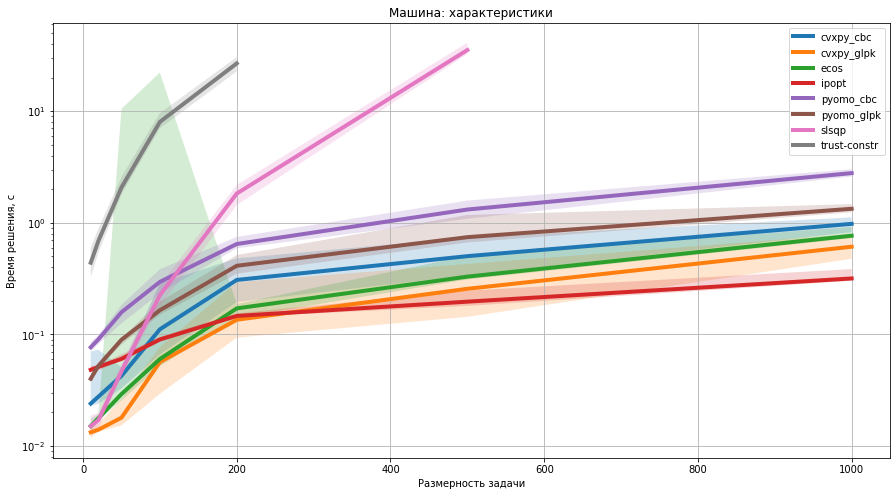

In [102]:
plt.figure(figsize=(15, 8))
for solver, df in time_rep_df.groupby(['solver']):
    plt.plot(df['N'], df['50%'], label=solver, lw=4)
    plt.fill_between(df['N'], df['25%'], df['75%'], alpha=0.2)
plt.yscale('log')
# plt.xscale('log')
plt.legend()
plt.xlabel('Размерность задачи')
plt.ylabel('Время решения, с')
plt.grid()
plt.title("Машина: характеристики")
plt.show()


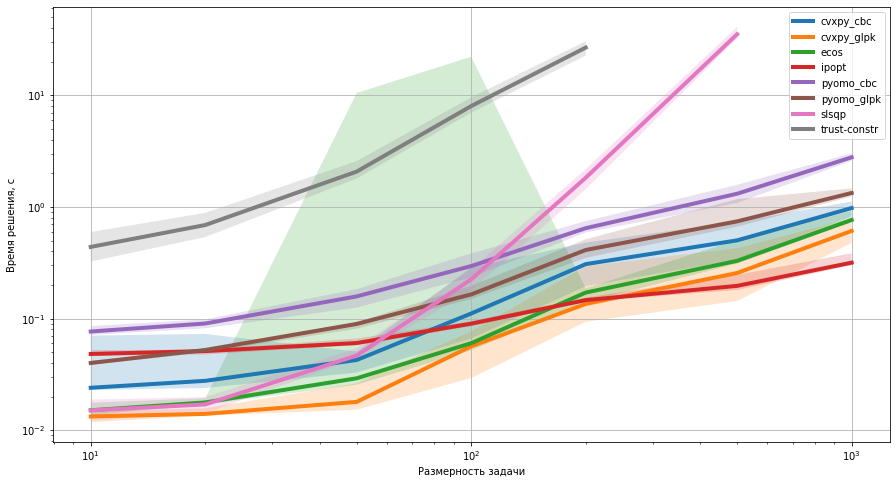

In [103]:
plt.figure(figsize=(15, 8))
for solver, df in time_rep_df.groupby(['solver']):
    plt.plot(df['N'], df['50%'], label=solver, lw=4)
    plt.fill_between(df['N'], df['25%'], df['75%'], alpha=0.2)
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.xlabel('Размерность задачи')
plt.ylabel('Время решения, с')
plt.grid()
plt.show()


In [104]:
stats_df.groupby(['solver'])['success'].mean()


solver
cvxpy_cbc       1.000000
cvxpy_glpk      1.000000
ecos            0.777143
ipopt           1.000000
pyomo_cbc       1.000000
pyomo_glpk      1.000000
slsqp           1.000000
trust-constr    0.960000
Name: success, dtype: float64

In [10]:
stats_df.query("not success")

,index,N,seed,solver,t,status,success
11,5,10,1,ecos,2.261557,optimal_inaccurate,False
47,5,10,7,ecos,1.484357,optimal_inaccurate,False
65,5,10,10,ecos,1.886401,infeasible_inaccurate,False
83,5,10,13,ecos,1.289926,infeasible_inaccurate,False
95,5,10,15,ecos,2.278549,optimal_inaccurate,False
113,5,10,18,ecos,1.266687,optimal_inaccurate,False
161,5,20,1,ecos,4.270821,optimal_inaccurate,False
173,5,20,3,ecos,4.760350,infeasible_inaccurate,False
185,5,20,5,ecos,4.673716,infeasible_inaccurate,False
191,5,20,6,ecos,2.993557,optimal_inaccurate,False


In [88]:
data_c = generate_data(10, 1)
data_c = construct_bounds(data_c, bounds_params)
# генерация данных для MILP оптимизации
data_d = construct_lp_grid(data_c, bounds_params, 21)
M_cur = sum(data_c['Q'] * (data_c['P'] - data_c['C']))
P_cur = sum(data_c['Q'] * data_c['P'])

opt_params = {
    'alpha': 0.0,
    'con_mrg': M_cur,
    'con_equal': True
}

In [98]:
%%time
res_cvx, t_cvx = pricing_optimization(data_d, CvxpyLpOptimizationModel, opt_params, 'ECOS_BB',
                                      solver_option={'max_iters': 1000})
# res_cbc, t_cbc = pricing_optimization(data_d, PyomoLpOptimizationModel, opt_params, 'glpk')

CPU times: user 2.04 s, sys: 5.14 ms, total: 2.05 s
Wall time: 2.05 s


In [99]:
res_cvx['model'].solution.attr['solver_specific_stats']['info']

{'exitFlag': 10,
 'pcost': -1244.9889973994493,
 'dcost': -1244.9889973755776,
 'pres': 1.3508151719502032e-10,
 'dres': 1.3386534420411526e-11,
 'pinf': 0.0,
 'dinf': 0.0,
 'pinfres': nan,
 'dinfres': 2.621038967052042,
 'gap': 2.623831338936334e-07,
 'relgap': 2.1075136763594138e-10,
 'r0': 1e-08,
 'iter': 6,
 'mi_iter': 999,
 'infostring': 'Maximum iterations reached with feasible solution found',
 'timing': {'runtime': 0.000671025,
  'tsetup': 0.000195804,
  'tsolve': 0.000475221},
 'numerr': 0}

In [47]:
res_cvx['model'].

<bound method Problem.constants of Problem(Maximize(Expression(AFFINE, NONNEGATIVE, ())), [Equality(Expression(AFFINE, NONNEGATIVE, (8,)), Constant(CONSTANT, NONNEGATIVE, ())), Inequality(Constant(CONSTANT, NONNEGATIVE, ()))])>

0.09386277198791504

In [19]:
t_cvx

0.014790058135986328

In [43]:
(
    sum(res_cbc['data']['P_opt'] * res_cbc['data']['Q_opt']), 
    sum(res_cvx['data']['P_opt'] * res_cvx['data']['Q_opt'])
)

(1471.0837287236425, 1469.999727391328)